In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd

plt.style.use('default')

### Proportional hazard tests and fixes

This Jupyter notebook is a small tutorial on how to test and fix proportional hazard problems. Recall that the proportional hazard assumption is that the ratio of the hazard of the $i$th individual and the baseline hazard is constant (that is, not a function of time). 

In [2]:
from lifelines.datasets import load_rossi
rossi = load_rossi()
cph = CoxPHFitter()

cph.fit(rossi, 'week', 'arrest')

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

In [3]:
cph.print_summary(model="untransformed variables")

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2018-12-30 23:55:55 UTC
             model = untransformed variables


---
      coef  exp(coef)  se(coef)     z      p  log(p)  lower 0.95  upper 0.95   
fin  -0.38       0.68      0.19 -1.98   0.05   -3.05       -0.75       -0.00  .
age  -0.06       0.94      0.02 -2.61   0.01   -4.71       -0.10       -0.01  *
race  0.31       1.37      0.31  1.02   0.31   -1.18       -0.29        0.92   
wexp -0.15       0.86      0.21 -0.71   0.48   -0.73       -0.57        0.27   
mar  -0.43       0.65      0.38 -1.14   0.26   -1.36       -1.18        0.31   
paro -0.08       0.92      0.20 -0.43   0.66   -0.41       -0.47        0.30   
prio  0.09       1.10      0.03  3.19 <0.005   -6.57        0.04        0.15  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0

### Checking assumptions with `check_assumptions`

New to lifelines 0.16.0 is the `CoxPHFitter.check_assumptions` method. This method will compute statistics that check the proportional hazard assumption, produce plots to check assumptions, and more. Also included is an option to display advice to the console. 


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
               test_statistic      p  log(p)    
age  identity           12.06 <0.005   -7.57  **
     km                 11.03 <0.005   -7.02  **
     log                13.07 <0.005   -8.11  **
     rank               11.09 <0.005   -7.05  **
fin  identity            0.06   0.81   -0.21    
     km                  0.02   0.89   -0.12    
     log                 0.49   0.48   -0.73    
     rank                0.02   0.90   -0.11    
mar  identity            0.75   0.39   -0.95    
     km                  0.60   0.44   -0.82    
     log                 1.03   0.31   -1.17    
     rank                0.67   0.41   -0.88    
paro identity            0.12   0.73   -0.32    
     km                  0.12   0.73   -0.31    
     log                 0.01   0.92   -0.09    
     rank                0.14   0.71   -0.34    
prio identity            0.01

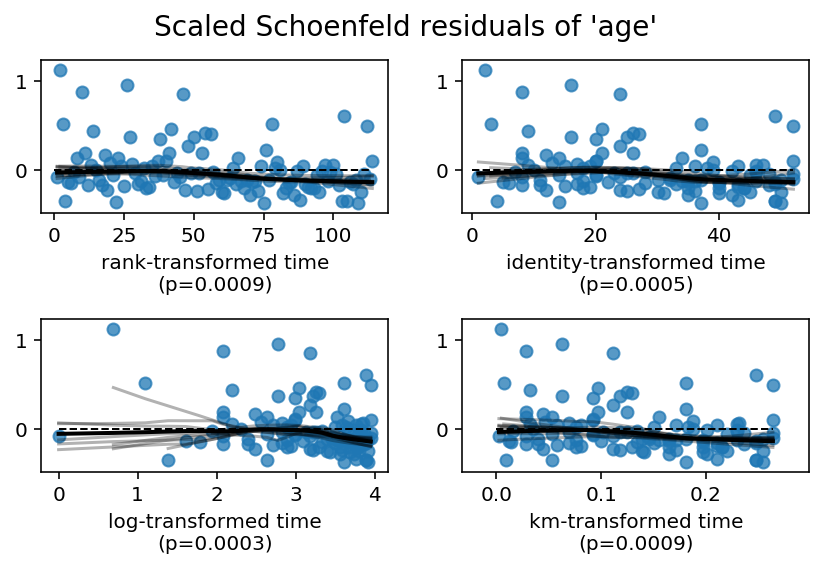

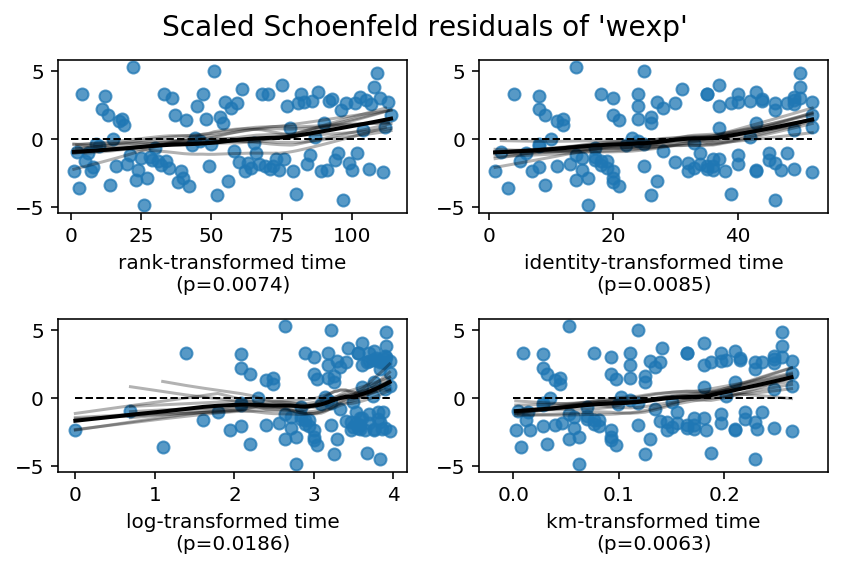

In [8]:
cph.check_assumptions(rossi, plot_n_bootstraps=10)

In [9]:
from lifelines.statistics import proportional_hazard_test
results = proportional_hazard_test(cph, rossi, time_transform='all')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
               test_statistic       p  log(p)    
age  identity          12.061   0.001  -7.571  **
     km                11.030   0.001  -7.017  **
     log               13.073 <0.0005  -8.113  **
     rank              11.094   0.001  -7.051  **
fin  identity           0.056   0.813  -0.207    
     km                 0.019   0.890  -0.117    
     log                0.491   0.483  -0.727    
     rank               0.017   0.896  -0.110    
mar  identity           0.754   0.385  -0.954    
     km                 0.601   0.438  -0.825    
     log                1.029   0.310  -1.170    
     rank               0.666   0.415  -0.881    
paro identity           0.122   0.727  -0.319    
     km                 0.116   0.734  -0.310    
     log                0.011   0.918  -0.085    
     rank         

In [10]:
# age is the most disobediant variable, so let's deal with that first. 
# one thing we can do is stratify the variable:

rossi['age_strata'] = pd.cut(rossi['age'], np.arange(0, 80, 3))

rossi[['age', 'age_strata']].head()

,age,age_strata
0,27,"(24, 27]"
1,18,"(15, 18]"
2,19,"(18, 21]"
3,23,"(21, 24]"
4,19,"(18, 21]"


In [11]:
# drop the orignal, redundant, age column
rossi = rossi.drop('age', axis=1)
cph.fit(rossi, 'week', 'arrest', strata=['age_strata'])

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

In [12]:
cph.print_summary(3, model="stratified age")

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
            strata = ['age_strata']
number of subjects = 432
  number of events = 114
    log-likelihood = -470.519
  time fit was run = 2018-12-30 23:58:56 UTC
             model = stratified age


---
       coef  exp(coef)  se(coef)      z     p  log(p)  lower 0.95  upper 0.95   
fin  -0.373      0.689     0.192 -1.941 0.052  -2.951      -0.750       0.004   
race  0.317      1.373     0.310  1.023 0.306  -1.183      -0.291       0.925   
wexp -0.101      0.904     0.215 -0.471 0.638  -0.450      -0.524       0.321   
mar  -0.399      0.671     0.387 -1.029 0.303  -1.193      -1.158       0.361   
paro -0.126      0.881     0.197 -0.640 0.522  -0.650      -0.513       0.260   
prio  0.091      1.095     0.029  3.187 0.001  -6.545       0.035       0.147  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1

Concordance = 0.640
Likelihood rat


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
               test_statistic    p  log(p)   
fin  identity            0.00 0.97   -0.03   
     km                  0.02 0.89   -0.12   
     log                 0.30 0.59   -0.53   
     rank                0.43 0.51   -0.67   
mar  identity            1.23 0.27   -1.32   
     km                  1.06 0.30   -1.20   
     log                 1.06 0.30   -1.19   
     rank                0.04 0.84   -0.18   
paro identity            0.08 0.78   -0.24   
     km                  0.08 0.78   -0.25   
     log                 0.09 0.76   -0.27   
     rank                1.66 0.20   -1.62   
prio identity            0.01 0.94   -0.07   
     km                  0.00 0.98   -0.02   
     log                 0.53 0.47   -0.77   
     rank                3.35 0.07   -2.70   
race identity            0.96 0.33   -1.12   
     km                  0.91 0.34

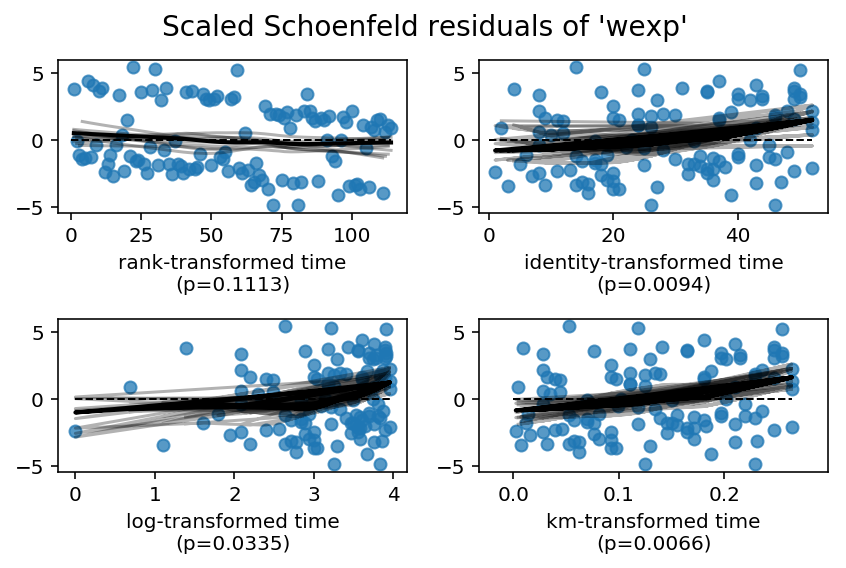

In [13]:
cph.check_assumptions(rossi)

In [14]:
cph.fit(rossi, 'week', 'arrest', strata=['age_strata', 'wexp'])

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

In [15]:
cph.check_assumptions(rossi)

Proportional hazard assumption looks okay.


<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
            strata = ['age_strata', 'wexp']
number of subjects = 432
  number of events = 114
    log-likelihood = -392.443
  time fit was run = 2018-12-30 23:59:09 UTC
             model = stratified age and wexp


---
       coef  exp(coef)  se(coef)      z     p  log(p)  lower 0.95  upper 0.95   
fin  -0.395      0.674     0.197 -2.004 0.045  -3.100      -0.781      -0.009  .
race  0.280      1.324     0.313  0.895 0.371  -0.992      -0.334       0.895   
mar  -0.194      0.824     0.392 -0.494 0.621  -0.476      -0.961       0.574   
paro -0.163      0.849     0.200 -0.818 0.413  -0.884      -0.555       0.228   
prio  0.080      1.084     0.028  2.855 0.004  -5.447       0.025       0.135  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1

Concordance = 0.640
Likelihood ratio test = 565.874 on 5 df, log(p)=-274.749


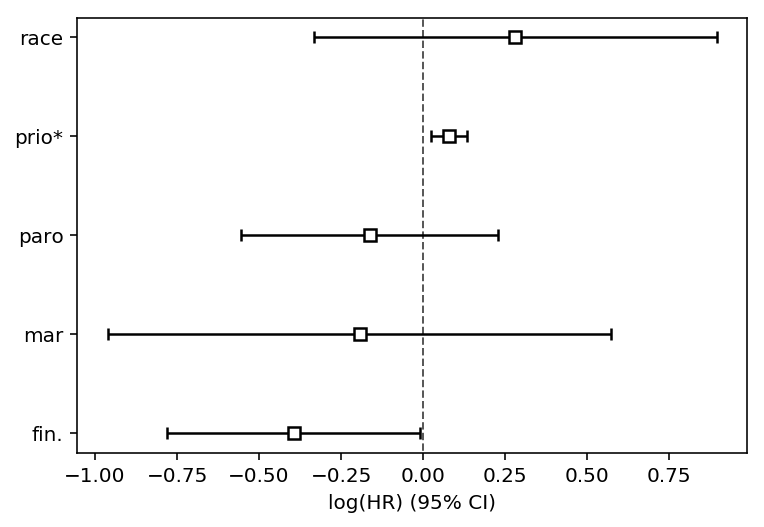

In [16]:
cph.print_summary(3, model="stratified age and wexp")
cph.plot()